# Import needed libraries

In [1]:
!pip install gurobipy --upgrade
!pip install pyqubo --upgrade
!pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 854.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys
import time
from collections import defaultdict
import re # to extract numbers from strings

import numpy as np
from numpy import linalg as la
import networkx as nx

# Gurobi libraries
import gurobipy as gp
from gurobipy import GRB

# DWave libraries
import dwave.cloud as dc
from dwave.cloud import Client
from dwave.system.samplers import DWaveSampler, LeapHybridSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from dimod import BinaryQuadraticModel
import neal

# Library to prepare QUBO formulation
from pyqubo import Array, Binary, Constraint, LogEncInteger

# Connect to DWave and choose solver

In [3]:
token = 'DEV-c9936a1f2108a4a1c2c8c2057e716bf150d0c88e'
endpoint = 'https://cloud.dwavesys.com/sapi'

In [4]:
# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
}

# Connect to the D-Wave system
client = dc.Client.from_config(**config)

# Print the available samplers and their names
for solver in client.get_solvers():
    print("Solver Name:", solver.id)

Solver Name: hybrid_binary_quadratic_model_version2
Solver Name: hybrid_discrete_quadratic_model_version1
Solver Name: hybrid_constrained_quadratic_model_version1
Solver Name: Advantage2_prototype1.1
Solver Name: Advantage_system6.2
Solver Name: Advantage_system4.1


In [5]:
# Specify the DWave solver name we want to use
solver = 'hybrid_binary_quadratic_model_version2'
# solver = 'Advantage_system6.2'

# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
    'solver': solver
}

# choose the sampler
# Simulated Annealing (classic sampler)
sampler = neal.SimulatedAnnealingSampler()
solver = 'SimulAnneal'

# hybrid sampler
# sampler = LeapHybridSampler(**config)

# # DWave sampler (pure quantum)
# sampler = DWaveSampler(**config)
# sampler = EmbeddingComposite(sampler) # DWave built-in embedding strategy
# # Create a D-Wave cloud client
# client = Client(**config)
# # Connect to the QPU
# qpu = client.get_solver()

# Generate a random graph

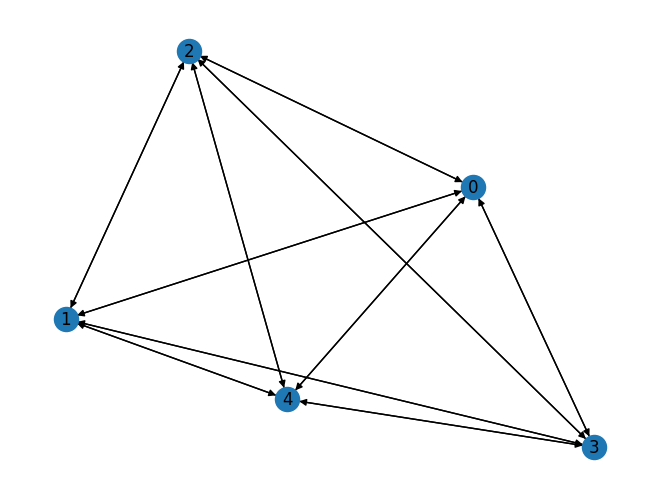

In [6]:
# number of nodes
n = 5

# since we want to solve basic VRP without taking into account capacities,
# we fix the maximum capacity C = n and customers' demands d = (1, ..., 1)
# this allows the vehicles to possibly visit all nodes,
# without restricting the routes

# maximum vehicle Capacity
C = n

# customers' demand
d = np.ones(n)

# heuristich bound of the number of vehicles needed to serve all customers
# To obtain the exact k_min we would need to solve a Bin Packing Problem
# Regardless, the heuristic bound usually works well too
kmin = int(np.ceil(np.sum(d)/C))

# number of vehicles
k = kmin + 1

# generate random Adjacency matrix
E = np.random.randint(0, 10, size=(n, n))
# make it symmetrical (to avoid getting stuck in dead ends)
E = E + E.T
# take away the diagonal
E = E - np.diag(np.diag(E))

# generate graph from Adjacency matrix
G = nx.from_numpy_array(E, create_using=nx.DiGraph)

# fix depot node
depot = 0

# draw Graph using Fruchterman-Reingold force-directed algorithm
nx.draw(G, nx.spring_layout(G), with_labels=True)

In [7]:
E

array([[ 0, 10,  8, 14, 12],
       [10,  0,  9,  4, 14],
       [ 8,  9,  0,  3, 12],
       [14,  4,  3,  0,  9],
       [12, 14, 12,  9,  0]])

# Useful functions

## TSP DFJ GAMA

In [8]:
def TSP_DFJ_gama(cluster):

################################################################################

  # useful function for Graver Augmentation

  # Objective function definition
  def f(x):
    return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

  # Constraints satisfaction
  def const(x):
      return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

################################################################################

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP_GAMA')
  # m.Params.LogToConsole = 0

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:

        # define slack variable for subtour elimination
      num_var_enc = int(np.ceil(np.log2(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j])+1)))
      for t in range(num_var_enc):
        s[(cont,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{cont},{t}]")

      m.update()

      # add subtour elimination constraint
      m.addConstr( -sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) +
                    (-1 + sum([2**t * s[(cont,t)] for t in range(num_var_enc-1)]) +
                    (sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) -
                    sum([2**t for t in range(num_var_enc-1)]))*s[(cont, num_var_enc-1)])   # s[cont]
                    == -1.0, name=f'subtour_elimination({cont})')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_GAMA.lp')

    # Run optimization engine
    A = m.getA()
    A = A.toarray()
    b = np.array(m.getAttr("RHS", m.getConstrs()), int)
    obj_coeffs = m.getAttr("Obj", m.getVars())

    # compute graver basis elements
    graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
    # print(len(graver_elems), ' graver elements found.')

    # compute feasible solutions
    feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
    # print(len(feas_sols), ' feasible solutions found.')

    # Multiseed Augmentation
    final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

    # get best solution
    x_opt = final_sols[np.argmin(final_obj_full), :]

    # get route
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j:
          route.append((i,j))

    route = [route[i] for i in range(len(route)) if x_opt[i]>1e-6]

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = f(x_opt)
  return (route, obj)

## TSP DFJ QUBO

In [9]:
def TSP_DFJ_qubo(cluster, p = np.sum(E)+1):

  cluster = set(cluster)
  n = len(cluster)

  # create QUBO variables for the edges
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = Binary(f'x[{i},{j}]')

  # ditionary of slack variables for subtour elimination constraints
  s = {}

  # count number of subtours
  cont = 0

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = sum(E[i,j]*x[(i,j)] for i in cluster for j in cluster if E[i,j]!=0 and i!=j)

  # add the objective
  Q =  obj

  # add the constraints
  # only one edge coming out from each node
  Q += p*sum([Constraint((sum([x[(i, j)] for j in cluster if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in cluster])

  # only one edge entering each node
  Q += p*sum([Constraint((sum([x[(i, j)] for i in cluster if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in cluster])

  while bool_subtour == True:

    if len(subtour)>0:
        s[cont] = LogEncInteger(f's[{cont}]', (-1, -1 + int(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]))))
        Q += p*(Constraint((-sum([x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) + s[cont] + 1)**2,
                          label=f'subtour_elimination_{t}'))
    # get QUBO matrix
    model = Q.compile()
    Q_dict, offset = model.to_qubo()

    # solve the model with the chosen sampler
    if solver=='SimulAnneal':   # classic solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, num_steps=1000)
    elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
      sampleset = sampler.sample_qubo(Q_dict)
    elif solver=='Advantage_system6.2':   # quantum solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

    # get obtained solutions
    samples = model.decode_sampleset(sampleset)

    # take only valid solutions (actual routes)
    samples = [s for s in samples if is_feasible(s.sample, s.energy)==True]

    # take only best solution (feasible and with minimum energy)
    best_sample = min(samples, key=lambda s: s.energy)

    # get best_sample's edges
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j and best_sample.sample[f'x[{i},{j}]'] > 1e-6:
          route.append((i, j))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*best_sample.sample[f'x[{i},{j}]']
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  return (route, obj)

In [10]:
def is_feasible(sample, energy):

  # original objective function value
  obj = np.sum([E[i,j]*sample[f'x[{i},{j}]']
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  return obj==energy

## TSP DFJ Gurobi

In [11]:
def TSP_DFJ_gurobi(cluster):

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP')

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:
      # add subtour elimination constraint
      m.addConstr(sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) >= 1, name='subtour_elimination')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_gurobi.lp')

    # Run optimization engine
    m.optimize()

    # get route
    route = []
    for v in m.getVars():
      if v.varName[0]=='x' and v.x > 1e-6:
        nodes_indices = re.findall(r'\d+', v.varName)
        route.append((int(nodes_indices[0]), int(nodes_indices[1])))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*x[(i,j)].X
                  for i in cluster
                  for j in cluster if E[i,j]!=0 and i!=j])

  return (route, obj)

## check subtours

In [12]:
def contains_subtours(cluster, edges, VERBOSE=False):

  n = len(cluster)
  routes = []
  unvisited_nodes = list(cluster)

  while len(unvisited_nodes)>0:
    route = []
    initial_node = unvisited_nodes[0]
    route.append(initial_node)
    next_node = [edge[1] for edge in edges if edge[0]==initial_node][0]
    route.append(next_node)
    while len(route)<n and next_node!=initial_node:
      next_node = [edge[1] for edge in edges if edge[0]==next_node][0]
      route.append(next_node)
    routes.append(route)

    # update list on not yet visited nodes
    unvisited_nodes = [node for node in unvisited_nodes if route.count(node)==0]

  if len(routes)>1:
    subtour = [route for route in routes if 0 not in route][0]
    if VERBOSE==True:
      print('subtour: \t', subtour)
    return (True, subtour)

  return (False, routes)

## check if clustering is a valid clustering

In [13]:
def is_valid_clustering(clusters, VERBOSE=False):

  # store the clusters
  clustering = []

  # get used vehicles
  vehicles = set([elem[0] for elem in clusters])

  # for each vehicle get the visited customers
  for vehicle in vehicles:
    clustering.append([elem[1] for elem in clusters if elem[0]==vehicle])

  # to be a valid clustering each node must be visited by exactly one vehicle
  # i.e. each node must appear in exactly one cluster
  cont = {}
  for i in range(1, n):
    cont[i] = sum([c.count(i) for c in clustering])
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid clustering: node served by multiple vehicles')
        print(clustering)
      return (False, clustering)

  # Also, the depot must be in each cluster
  cont[0] = sum([c.count(0) for c in clustering])
  if cont[0]!=len(clustering):
    if VERBOSE==True:
      print('Not a valid clustering: depot not in every cluster')
      print(clustering)
    return (False, clustering)

  # Moreover, the capacity of each vehicle must not be exceeded
  for c in clustering:
    if sum([d[node] for node in c])>C:
      if VERBOSE==True:
        print('Not a valid clustering: capacity exceeded')
        print(clustering)
      return (False, clustering)

  if VERBOSE==True:
    print('Valid clustering')
    print(clustering)

  return (True, clustering)

## get clusters from annealing sample

In [14]:
def get_clusters_from_sample(sample):
  clusters = []
  for v in range(k):
    for i in range(n):
      if sample[f'z[{v},{i}]']==1:
        clusters.append((v, i))
  return clusters

## check if feasible solution is an actual route

In [15]:
def is_valid_routing(edges, VERBOSE=False, formulation=1):

  # here we save the final routes (if any)
  routes = []

  # get starting edges of each route
  if formulation==1:
    for edge in edges:    # edge = (node i, node j)
      if edge[0]==0:
        routes.append([edge[0], edge[1]])

    # attempt to build the routes
    for i in range(len(routes)):
      # build route for i-th vehicle
      next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
      if next_nodes == []:
        pass
      elif len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
        if VERBOSE==True:
          print('Not a valid routing')
        return (False, routes)
      else:
        next_node = next_nodes[0]
        routes[i].append(next_node)
        while (len(routes[i])<n) and (next_node!=0) and (next_nodes!=[]):
          next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
          if len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
            if VERBOSE==True:
              print('Not a valid routing')
            return (False, routes)
          elif len(next_nodes) == 1:
            next_node = next_nodes[0]
            routes[i].append(next_node)

  elif formulation==2:
    for v in range(k):
      # take nodes visited by v-th vehicle
      nodes_vth_veich = sorted([edge for edge in edges if edge[0]==v], key=lambda x: x[2])    # edge = (vehicle, node, timestep)
      # check time consistency (one node per time step)
      time_steps = [node[2] for node in nodes_vth_veich]
      if time_steps != [i for i in range(n)]:
        if VERBOSE==True:
          print('Not a valid routing')
        return (False, routes)
      else:
        routes.append([node[1] for node in nodes_vth_veich])

  # for each route, check wheter the first and last nodes are zero (depot)
  for route in routes:
    first_node = route[0]
    last_node = route[-1]
    if first_node!=0 or last_node!=0:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  # count the number of times each node appears among the routes
  cont = {}
  for i in range(n):
    cont[i] = sum([route.count(i) for route in routes])

  # the depot must be visited 2*k times
  # k edges leaving the depot
  # k edges returning to the depot
  if cont[0]!=2*k:
    if VERBOSE==True:
        print('Not a valid routing')
    return (False, routes)

  # check wether each other node is visited exactly once
  for i in range(1, n):
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  if VERBOSE==True:
    print('Valid routing. The routes are\n')
    for route in routes:
      print(route)

  return (True, routes)

## get visited edges from annealing sampling

In [16]:
# get edges
def get_edges_from_sample(sample, formulation=1):

  edges = []

  if formulation==1:
    for i in range(n):
      for j in range(n):
        if i!=j:
          if sample[f'x[{i},{j}]']==1:
            edges.append((i, j))

  elif formulation==2:
    for v in range(k):
      for i in range(n):
        for j in range(n):
          if sample[f'x[{v}][{i}][{j}]']==1:
            edges.append((v, i, j))

  return edges

## Graver Augmentation

In [17]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
  return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
  for i, val in enumerate(iterable):  #[i = graver element, val=(obj, step_size)]
      if val[1] != 0:
          return i, val
  return i, val

In [18]:
# We can just have a single step move (works well with greedy approach)
def single_move(g, fun, x, x_lo = None, x_up = None):
  if x_lo is None:
      x_lo = np.zeros_like(x)
  if x_up is None:
      x_up = np.ones_like(x)

  alpha = 0

  if (x + g <= x_up).all() and (x + g >= x_lo).all():
      if fun(x + g) < fun(x):
          alpha = 1
  elif (x - g <= x_up).all() and (x - g >= x_lo).all():
      if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
          alpha = -1

  return (fun(x + alpha*g), alpha)

In [19]:
def augmentation(grav, func, x, x_lo = np.zeros(n*n), x_up = np.ones(n*n), VERBOSE = True, itermax = 1000):
  # Let's perform the augmentation and return the number of steps and the best solution
  # OPTION = 3 # Greedy augmentation, select using first found
  dist = 1
  gprev = None
  k = 1
  if VERBOSE:
      print("Initial point:", x)
      print("Objective function:",func(x))
  while dist != 0 and k < itermax:
    g1, (obj, dist) = greedy(single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
    x = x + grav[g1]*dist
    gprev = grav[g1]
    if VERBOSE:
        print("Iteration ", k)
        print('Graver element, (obj, alpha):', g1, (obj, dist))
        print("Augmentation direction:", gprev)
        print("Objective function:", func(x))
        print("Current point:", x)
        print("Are constraints satisfied?", const(x))
    else:
        if k%50 == 0:
            print(k)
            print(obj)
    k += 1
  return(k, obj, x)

In [20]:
def get_feasible(A, b, sampler, samples=500, refine_almost_feasible=False):

  AA = np.dot(A.T, A)
  h = -2.0*np.dot(b.T, A)
  Q = AA + np.diag(h)
  offset = np.dot(b.T, b) + 0.0

  # Define Binary Quadratic Model
  bqm = dimod.BinaryQuadraticModel(Q, "BINARY", offset=offset)

  # solve the model with the chosen sampler
  if solver=='SimulAnneal':   # classic solver
    response = sampler.sample(bqm, num_reads=samples, num_steps=1000)
  elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
    response = sampler.sample(bqm)
  elif solver=='Advantage_system6.2':   # quantum solver
    response = sampler.sample(bqm, num_reads=samples, annealing_time=qpu.properties["annealing_time_range"][1])

  # remove duplicates from the sample set
  response = response.aggregate()

  filter_idx = [i for i, e in enumerate(response.record.energy) if e == 0.0] # get only actual feasible solutions
  feas_sols = response.record.sample[filter_idx]

  # feas_sols contains the actual solutions of the QUBO problem,
  # namely those x such that Ax=0 (to get graver elems) and Ax=b (to get feasible solutions)
  # Usually, when solving for the graver elements it might happen that we also find several
  # low energy solutions y such that Ay ~ 0 but Ay!=0.
  # Instead of discarding such y's, it is convenient to combine them in order
  # to create new graver elements. That's what we do in the next lines of code

  if refine_almost_feasible==True:

    # get unfeasible solutions
    filter_idx = [i for i, e in enumerate(response.record.energy) if e != 0.0]
    sols = response.record.sample[filter_idx]
    # compute error matrix
    Error_matrix = np.dot(A, sols.T)

    # almost feasible solutions with gap-value of 1
    err_one_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==1]
    almost_feas_sols_1 = sols[err_one_sols]
    # create new feasible solutions
    feas_sols_1 = filter_sol_abs_error(A, almost_feas_sols_1, abs_error=1)
    # stack everything togheter
    if feas_sols_1.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_1])

    # almost feasible solutions with gap-value of 2
    err_two_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==2]
    almost_feas_sols_2 = sols[err_two_sols]
    # create new feasible solutions
    feas_sols_2 = filter_sol_abs_error(A, almost_feas_sols_2, abs_error=2)
    # stack everything togheter
    if feas_sols_2.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_2])

  # remove duplicate solutions
  feas_sols = np.unique(feas_sols, axis=0)
  return feas_sols

In [21]:
# this functions takes as input a set of almost feasible solutions
# and combines them to create new actual feasible solutions
def filter_sol_abs_error(A, sols, abs_error=1):

  plus_one_group = []
  minus_one_group = []
  for i in range(sols.shape[0]):
    if np.sum(np.dot(A, sols[i].T))==abs_error:
      plus_one_group.append(sols[i])
    elif np.sum(np.dot(A, sols[i].T))==-abs_error:
      minus_one_group.append(sols[i])

  plus_one_group = np.array(plus_one_group)
  minus_one_group = np.array(minus_one_group)

  new_sols = []

  for i in range(plus_one_group.shape[0]):
    for j in range(i, plus_one_group.shape[0]):
      curr_sol = plus_one_group[i] - plus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(minus_one_group.shape[0]):
    for j in range(i, minus_one_group.shape[0]):
      curr_sol = minus_one_group[i] - minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(plus_one_group.shape[0]):
    for j in range(minus_one_group.shape[0]):
      curr_sol = plus_one_group[i] + minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)

  new_sols = np.array(new_sols)
  return new_sols

In [22]:
def graver_multiseed_augmentation(feas_sols, graver_elems, const, f):

  if len(feas_sols)==0:
    print('No feasible solutions to augment')
    return

  init_obj = np.zeros((len(feas_sols)))
  iters_full = np.zeros((len(feas_sols)))
  final_obj_full = np.zeros((len(feas_sols)))
  times_full = np.zeros((len(feas_sols)))
  final_sols = np.zeros(shape=(len(feas_sols), feas_sols[0].shape[0]))

  for i, sol in enumerate(feas_sols):
    if not const(sol):
      print("Infeasible")
      pass
    init_obj[i] = f(sol)
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = graver_elems, func = f, x = sol,
                                   x_lo = np.zeros(feas_sols[0].shape[0]),
                                   x_up = np.ones(feas_sols[0].shape[0]),
                                   VERBOSE=False)
    times_full[i] = time.process_time() - start
    iters_full[i] = iter
    final_obj_full[i] = f_obj
    final_sols[i, :] = xf

  return (final_sols, final_obj_full)

# CVRP with exactly k vehicles

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(0)} x_{0j} = k \\
& \sum_{j \in N^{-}(0)} x_{j0} = k \\
& \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j=1, \dots, n-1 \\
& u_i - u_j + Cx_{ij} \leq C - d_j \quad \forall i \neq j \in \{1, \dots, n-1\}, \,\, \text{with} \,\, d_i+d_j\leq C\\
& d_i \leq u_i \leq C \quad \forall i=1, \dots, n-1\\
& u_i \in \mathbf{Z}_{+} \quad \forall i=1, \dots, n-1\\
& x_{ij} \in \{0, 1\} \quad \forall i,j=0, \dots, n-1
\end{alignat*}

## Gurobi

In [23]:
# Declare and initialize model
m = gp.Model('VRP')

Restricted license - for non-production use only - expires 2024-10-28


### Decision variables

In [24]:
# Create decision variables

# edge variables
x = {}
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

# capacity variables
u = {}
for i in range(1, n):
  u[i] = m.addVar(vtype=GRB.INTEGER, name=f"u[{i}]")

# update model
m.update()

### Constraints

In [25]:
# k vehicle departing from depot
m.addConstr(sum(x[(0, j)] for j in range(1, n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[(j, 0)] for j in range(1, n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[(i, j)] for i in range(n) if E[i, j]!=0 and i!=j) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[(i, j)] for j in range(n) if E[i, j]!=0 and i!=j) == 1 for i in range(1, n)), name='leave_node')

# Capacity Cut Constraints
m.addConstrs(((u[i]-u[j]+C*x[(i,j)] <= C-d[j]) for i in range(1, n) for j in range(1, n) if E[i,j]!=0 and i!=j and d[i]+d[j]<=C), name='CCCs')
m.addConstrs(((d[i] - u[i] <= 0) for i in range(1, n)), name='capacity_constraints_lb')
m.addConstrs(((u[i] <= C) for i in range(1, n)), name='capacity_constraints_ub')

# update model
m.update()

### Objective function

In [26]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n) if E[i,j]!=0 and i!=j])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [27]:
# Save model for inspection
m.write('VRP.lp')

In [28]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 24 columns and 84 nonzeros
Model fingerprint: 0x7059dd43
Variable types: 0 continuous, 24 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 71.0000000
Presolve removed 8 rows and 0 columns
Presolve time: 0.00s
Presolved: 22 rows, 24 columns, 76 nonzeros
Variable types: 0 continuous, 24 integer (20 binary)

Root relaxation: objective 4.840000e+01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   48.40000    0    4   71.00000

### Routes

In [29]:
# get non zero decision variables (only x's)
routes = []
for v in m.getVars():
  if v.varName[0]=='x' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(True, [[0, 1, 3, 2, 0], [0, 4, 0]])

## QUBO

### Define the variables

In [30]:
# create QUBO variables for the edges
x = {}
for i in range(n):
  for j in range(n):
    if i!=j:
      x[(i,j)] = Binary(f'x[{i},{j}]')

# create QUBO variables for CCCs
# since each u[i] is Integer, we need to encode it using binary variables
# we use logarithmic encoding to reduce the number of variables
u = {}
for i in range(1, n):
  u[i] = LogEncInteger(f'u[{i}]', (int(d[i]), C))

# we also need to introduce slack variables for the CCCs
# Normally the slack variables would be integer, so we need
# to binary encode them too. As before, we use logarithmic encoding
s = {}
for i in range(1, n):
  for j in range(1, n):
    if E[i,j]!=0 and i!=j and d[i]+d[j]<=C:
      s[(i, j)] = LogEncInteger(f's[({i}, {j})]', (-C, 2*C-int(d[i])-int(d[j])))

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [31]:
# build QUBO by manually adding objective and constraints

# define objective function
obj = sum(E[i,j]*x[(i,j)] for i in range(n) for j in range(n) if E[i,j]!=0 and i!=j)

# add the objective
Q =  obj

# add the constraints
# penalize the usage of non-existing edges, if there are any
if len([1 for i in range(n) for j in range(n) if i!=j and E[i,j]==0])>0:
  Q += p*(Constraint(sum([x[(i, j)] for i in range(n) for j in range(n) if E[i, j]==0 and i!=j]), label='non_existing_edges'))

# k vehicles leaving the depot
Q += p*(Constraint((sum([x[(0, j)] for j in range(1, n) if E[0, j]!=0])-k)**2, label='leave_depot'))

# k vehicles returning to depot
Q += p*(Constraint((sum([x[(j, 0)] for j in range(1, n) if E[j, 0]!=0])-k)**2, label='return_depot'))

# only one edge coming out from each node
Q += p*sum([Constraint((sum([x[(i, j)] for j in range(n) if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in range(1, n)])

# only one edge entering each node
Q += p*sum([Constraint((sum([x[(i, j)] for i in range(n) if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in range(1, n)])

# Capacity Cut Constraints
Q += p*sum([Constraint((u[i] - u[j] + C*x[(i,j)] + s[(i,j)] - C + d[j])**2,
                       label=f'CCC({i},{j})') for i in range(1, n) for j in range(1, n)
                       if E[i,j]!=0 and i!=j and d[i]+d[j]<=C])

In [32]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('s[(1, 4)][0]', 'x[1,4]'): 1910.0,
 ('x[4,2]', 'u[2][0]'): -1910.0,
 ('u[1][1]', 'x[2,1]'): -3820.0,
 ('u[3][2]', 's[(3, 4)][3]'): 2292.0,
 ('u[1][0]', 'u[1][0]'): 1146.0,
 ('x[2,3]', 'x[1,3]'): 382.0,
 ('u[2][0]', 's[(1, 2)][2]'): -1528.0,
 ('u[4][2]', 's[(2, 4)][1]'): -764.0,
 ('u[1][0]', 's[(1, 2)][2]'): 1528.0,
 ('u[1][2]', 'u[1][2]'): 1146.0,
 ('x[4,0]', 'x[4,0]'): -752.0,
 ('u[4][2]', 's[(1, 4)][1]'): -764.0,
 ('u[2][2]', 's[(2, 3)][0]'): 382.0,
 ('u[4][2]', 's[(2, 4)][2]'): -1528.0,
 ('s[(2, 4)][1]', 's[(2, 4)][0]'): 764.0,
 ('s[(1, 2)][3]', 'x[1,2]'): 11460.0,
 ('u[3][1]', 'u[1][2]'): -1528.0,
 ('x[1,2]', 'x[0,2]'): 382.0,
 ('u[4][0]', 'x[1,4]'): -1910.0,
 ('u[1][1]', 's[(2, 1)][3]'): -4584.0,
 ('s[(3, 1)][1]', 's[(3, 1)][0]'): 764.0,
 ('x[0,4]', 'x[0,3]'): 382.0,
 ('u[3][0]', 's[(1, 3)][0]'): -382.0,
 ('u[3][2]', 's[(2, 3)][2]'): -1528.0,
 ('s[(4, 3)][3]', 's[(4, 3)][1]'): 4584.0,
 ('x[4,3]', 'x[4,3]'): -12788.0,
 ('s[(1, 3)][3]', 's[(1, 3)][1]'): 4584.0,
 ('s[(4, 2)][1]', '

### Solve QUBO

In [33]:
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual routes)
samples = [s for s in samples if is_valid_routing(get_edges_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'x[4,1]': 0, 'x[4,0]': 1, 'x[3,4]': 0, 'x[3,2]': 0, 'x[1,4]': 0, 'x[1,3]': 0, 'x[1,2]': 0, 'x[0,4]': 1, 'x[0,2]': 1, 'x[0,1]': 0, 's[(3, 1)][0]': 0, 'x[1,0]': 1, 'u[3][1]': 0, 's[(2, 3)][3]': 0, 's[(2, 3)][0]': 1, 's[(2, 4)][3]': 0, 'u[4][0]': 0, 'x[4,2]': 0, 'x[2,1]': 0, 's[(4, 3)][1]': 0, 'u[3][2]': 1, 's[(4, 1)][0]': 0, 's[(2, 1)][2]': 1, 's[(3, 2)][2]': 1, 's[(3, 2)][1]': 0, 's[(2, 1)][1]': 0, 's[(1, 2)][0]': 0, 'x[4,3]': 0, 's[(1, 2)][1]': 1, 's[(2, 4)][2]': 1, 's[(4, 3)][0]': 0, 's[(3, 1)][3]': 0, 's[(2, 4)][0]': 1, 's[(1, 4)][0]': 0, 's[(4, 3)][3]': 1, 's[(2, 1)][0]': 0, 's[(2, 4)][1]': 1, 's[(2, 3)][1]': 1, 'x[2,0]': 0, 's[(4, 2)][3]': 1, 's[(1, 2)][3]': 1, 'x[3,1]': 1, 'x[0,3]': 0, 's[(1, 3)][0]': 1, 's[(1, 3)][1]': 0, 's[(1, 2)][2]': 0, 's[(1, 3)][3]': 1, 's[(3, 4)][3]': 1, 's[(2, 1)][3]': 1, 's[(1, 4)][2]': 1, 's[(4, 2)][1]': 0, 's[(3, 1)][2]': 1, 'u[4][2]': 1, 's[(2, 3)][2]': 0, 'x[3,0]': 0, 's[(1, 4)][1]': 1, 'x[2,3]': 1, 'u[3][0]': 1, 's[(1, 3)][2]': 0, 's[(3, 2)][0]': 0

In [34]:
# compute original objective function value in best_sample
x = np.zeros((n,n))

if best_sample != None:
  for i in range(n):
    for j in range(n):
      if i!=j:
        x[i, j] = best_sample.sample[f'x[{i},{j}]']

  # original objective function value
  print(sum(E[i,j]*x[i,j] for i in range(n) for j in range(n)))

49.0


### Routes

In [35]:
# get non zero decision variables
routes = []
for i in range(n):
  for j in range(n):
    if x[i, j] > 1e-6:
      routes.append((i, j))

is_valid_routing(routes, VERBOSE=True)

Valid routing. The routes are

[0, 2, 3, 1, 0]
[0, 4, 0]


(True, [[0, 2, 3, 1, 0], [0, 4, 0]])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [36]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('VRP_GAMA')

# Create edges variables
x = {}
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

# Create capacity variables
u = {}
for i in range(1, n):
  num_var_enc = int(np.ceil(np.log2(C-d[i]+1)))    # u_i = d[i] + sum([2^j * u[i,j] for j in range(num_var_enc-1)]) + (C-sum([2^j for j in range(num_var_enc-1)]))*u[i,num_var_enc]
  for j in range(num_var_enc):
    u[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"u[{i},{j}]")

# Create slack variables for CCCs
s = {}
for i in range(1, n):
  for j in range(1, n):
    if E[i,j]!=0 and i!=j and d[i]+d[j]<=C:
      num_var_enc = int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))   # s_ij = -C + sum([2^t * s[i,j,t] for t in range(num_var_enc-1)])+ (2C-d[i]-d[j]-sum([2^j for j in range(num_var_enc-1)]))*s[i,j,num_var_enc]
      for t in range(num_var_enc):
        s[(i,j,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{i},{j},{t}]")

m.update()

### Define constraints

In [37]:
# k vehicle departing from depot
m.addConstr(sum(x[(0, j)] for j in range(1, n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[(j, 0)] for j in range(1, n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[(i, j)] for i in range(n) if E[i, j]!=0 and i!=j) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[(i, j)] for j in range(n) if E[i, j]!=0 and i!=j) == 1 for i in range(1, n)), name='leave_node')

# Capacity Cut Constraints with slack variables and logarithmic binary encoding
m.addConstrs((((d[i] + sum([2**t * u[(i,t)] for t in range(int(np.ceil(np.log2(C-d[i]+1)))-1)]) +
                (C-sum([2**t for t in range(int(np.ceil(np.log2(C-d[i]+1)))-1)])-d[i])
                *u[(i,int(np.ceil(np.log2(C-d[i]+1)))-1)])    # u[i]
               -(d[j] + sum([2**t * u[(j,t)] for t in range(int(np.ceil(np.log2(C-d[j]+1)))-1)]) +
                 (C-sum([2**t for t in range(int(np.ceil(np.log2(C-d[j]+1)))-1)])-d[j])*
                 u[(j,int(np.ceil(np.log2(C-d[j]+1)))-1)])    # u[j]
               +C*x[(i,j)]
               + (-C + sum([(2**t)*s[(i,j,t)] for t in range(int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]) +
                  ((3*C-d[i]-d[j]-sum([2**t for t in range(int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]))*
                   s[(i,j,int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]))    # s[i,j] slack variable
               == C-d[j]) for i in range(1, n) for j in range(1, n)
               if E[i,j]!=0 and i!=j and d[i]+d[j]<=C), name='CCCs')

m.update()

### Define objective

In [38]:
# Define objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n) if E[i,j]!=0 and i!=j])

m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Optimize the model via Gurobi

In [39]:
# Save model for inspection
m.write('VRP_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 22 rows, 80 columns and 172 nonzeros
Model fingerprint: 0x2a3c8ce8
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 12 rows and 60 columns
Presolve time: 0.00s
Presolved: 10 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective 54.0000000

Root relaxation: objective 4.800000e+01, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      48.00000

In [40]:
# get non zero decision variables (only x's)
routes = []
for v in m.getVars():
  if v.varName[0]=='x' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(False, [[0, 2, 0], [0, 4, 0]])

### Retrieve constraint matrix

In [41]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)
obj_coeffs = m.getAttr("Obj", m.getVars())

# create decision variables
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [42]:
# Objective function definition
def f(x):
  return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [43]:
# con = []
# for c in m.getConstrs():
#   if c.ConstrName == "leave_node[4]":
#     con.append(c)

# con = con[0]

# print(f"{m.getRow(con)} {con.Sense} {con.RHS}")

In [44]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [45]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

40  graver elements found.


In [46]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

3  feasible solutions found.


In [47]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1.] 59.0


### Routes

In [48]:
edges = []
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      edges.append((i,j))

edges = [edges[i] for i in range(len(edges)) if x_opt[i]>1e-6]

print(edges)

is_valid_routing(edges, VERBOSE=True)

[(0, 3), (0, 4), (1, 2), (2, 0), (3, 1), (4, 0)]
Valid routing. The routes are

[0, 3, 1, 2, 0]
[0, 4, 0]


(True, [[0, 3, 1, 2, 0], [0, 4, 0]])

# 2-Phase Heuristic: Clustering (Multi-Knapsack Problem)

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{v} \sum_{i, j} c_{ij}z_{v,i}z_{v,j} \\
\text{subject to} \quad & \sum_{v = 0}^{k-1} z_{v,0} = k \\
& \sum_{v = 0}^{k-1} z_{v,i} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i = 1}^{n-1} d_iz_{v,i} \leq C \quad \forall v=0, \dots, k-1 \\
& z_{v,i} \in \{0, 1\} \quad \forall v=0, \dots, k-1; \,\, i=0, \dots, n-1
\end{alignat*}

## Gurobi

In [49]:
# Declare and initialize model
m = gp.Model('MKP')

### Decision variables

In [50]:
# Create decision variables

# edge variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# update model
m.update()

### Constraints

In [51]:
# the depot must be in each cluster
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='depot_in_every_cluster')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) <= C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Objective function

In [52]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [53]:
# Save model for inspection
m.write('MKP.lp')

# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 10 columns and 18 nonzeros
Model fingerprint: 0x85d697a7
Model has 20 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 190.0000000
Presolve removed 7 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 120 190 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+02, best bound 1.200000000000e+02, gap 0.0

### Clusters

In [54]:
# get customers
clusters = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(True, [[0, 1, 2, 3], [0, 4]])

## QUBO

### Define the variables

In [55]:
# create QUBO variables for the edges
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = Binary(f'z[{v},{i}]')

# create slack variables for capacity constraints
# Normally the slack variables would be integer, so we need to binary encode them.
# As usual, we use logarithmic encoding to reduce the number of variables
s = {}
for v in range(k):
  s[v] = LogEncInteger(f's[{v}]', (C-int(sum(d[1:])), C))

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [56]:
# build QUBO by manually adding objective and constraints

# define objective function
obj = sum([E[i,j]*z[(v,i)]*z[(v,j)]
          for i in range(n)
          for j in range(n)
          for v in range(k)])

# add the objective
Q =  obj

# add the constraints
# depot assigned to each cluster
Q += p*(Constraint((sum([z[(v, 0)] for v in range(k)])-k)**2, label=f'depot_in_every_cluster'))

# each customer assigned to exactly one vehicle
Q += p*sum([Constraint((sum([z[(v, i)] for v in range(k)])-1)**2, label=f'assign_node_{i}') for i in range(1, n)])

# Capacity Constraints
Q += p*sum([Constraint((sum([d[i]*z[(v,i)] for i in range(1, n)]) + s[v] - C)**2,
                       label=f'capacity({v})') for v in range(k)])

In [57]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('z[1,4]', 'z[1,4]'): -1528.0,
 ('s[0][1]', 'z[0,3]'): 764.0,
 ('s[0][2]', 'z[0,4]'): 382.0,
 ('z[1,2]', 'z[1,0]'): 16.0,
 ('s[1][2]', 's[1][2]'): -1337.0,
 ('z[0,1]', 'z[0,1]'): -1528.0,
 ('z[1,3]', 'z[1,1]'): 390.0,
 ('z[1,3]', 'z[1,0]'): 28.0,
 ('s[1][0]', 'z[1,1]'): 382.0,
 ('s[1][1]', 'z[1,4]'): 764.0,
 ('z[0,1]', 'z[0,0]'): 20.0,
 ('s[0][1]', 'z[0,2]'): 764.0,
 ('s[1][2]', 's[1][1]'): 764.0,
 ('z[0,4]', 'z[0,2]'): 406.0,
 ('z[1,0]', 'z[0,0]'): 382.0,
 ('s[0][0]', 'z[0,1]'): 382.0,
 ('s[1][1]', 'z[1,3]'): 764.0,
 ('s[1][0]', 'z[1,3]'): 382.0,
 ('s[0][2]', 'z[0,2]'): 382.0,
 ('s[0][0]', 's[0][0]'): -1337.0,
 ('s[0][2]', 'z[0,3]'): 382.0,
 ('z[1,4]', 'z[1,0]'): 24.0,
 ('z[0,0]', 'z[0,0]'): -573.0,
 ('z[0,3]', 'z[0,0]'): 28.0,
 ('s[1][1]', 'z[1,2]'): 764.0,
 ('s[0][0]', 'z[0,3]'): 382.0,
 ('z[0,2]', 'z[0,2]'): -1528.0,
 ('z[1,1]', 'z[1,1]'): -1528.0,
 ('s[1][0]', 'z[1,2]'): 382.0,
 ('s[1][1]', 's[1][0]'): 764.0,
 ('s[0][2]', 's[0][0]'): 382.0,
 ('z[0,3]', 'z[0,1]'): 390.0,
 ('s[1][2

### Solve QUBO

In [58]:
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual clusterings)
samples = [s for s in samples if is_valid_clustering(get_clusters_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'z[1,4]': 1, 'z[1,3]': 0, 'z[1,2]': 0, 's[0][1]': 0, 'z[0,3]': 1, 's[0][2]': 1, 's[1][0]': 0, 's[1][1]': 1, 's[1][2]': 1, 'z[0,1]': 1, 's[0][0]': 0, 'z[0,2]': 1, 'z[0,4]': 0, 'z[1,0]': 1, 'z[0,0]': 1, 'z[1,1]': 0} 
 120.0


In [59]:
# compute original objective function value in best_sample
z = {}

if best_sample != None:
  for v in range(k):
    for i in range(1, n):
      z[(v, i)] = best_sample.sample[f'z[{v},{i}]']

  # original objective function value
  obj = np.sum([E[i,j]*z[(v,i)]*z[(v,j)]
              for i in range(1, n)
              for j in range(1, n)
              for v in range(k)])
  print(obj)

32


### Clusters

In [60]:
# check if solution is a valid clustering
is_valid_clustering(get_clusters_from_sample(best_sample.sample))

(True, [[0, 1, 2, 3], [0, 4]])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [61]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('MKP_GAMA')

# Create edges variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# Create slack variables for capacity constraints
s = {}
for v in range(k):
  num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
  for t in range(num_var_enc):
    s[(v,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{v},{t}]")

m.update()

### Define constraints

In [62]:
# depot must be in each knapsack
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='each_customer_to_one_vehicle')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) +
              (C - int(sum(d[1:])) + sum([2**t * s[(v,t)] for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]) +
              (int(sum(d[1:]))-sum([2**t for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]))
              *s[(v,int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)])   # s[v]
              == C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Define objective

In [63]:
# Objective: minimize total cost of all assignments
obj = sum(E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k))

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize the model via Gurobi

In [64]:
# Save model for inspection
m.write('MKP_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 16 columns and 24 nonzeros
Model fingerprint: 0x399f7976
Model has 20 quadratic objective terms
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 122.0000000
Presolve removed 7 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 120 122 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+02, best bound 1.200000000000e+02, gap 0.0

In [65]:
# get non zero decision variables (only x's)
clusters = []
for v in m.getVars():
  if v.varName[0]=='z' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(True, [[0, 1, 2, 3], [0, 4]])

### Retrieve constraint matrix

In [66]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)

# create decision variables
num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [67]:
# Objective function definition
def f(x):
  y = x[:k*n, ]
  y = y.reshape((k, n))
  obj = sum(E[i,j]*y[v,i]*y[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k))
  return obj

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [68]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [69]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

1  graver elements found.


In [70]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

47  feasible solutions found.


In [71]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.] 120.0


### Clusters

In [72]:
clusters = []
for v in range(k):
  for i in range(n):
    clusters.append((v,i))

clusters = [clusters[i] for i in range(len(clusters)) if x_opt[i]>1e-6]

print(clusters)

is_valid_clustering(clusters, VERBOSE=True)

[(0, 0), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3)]
Valid clustering
[[0, 4], [0, 1, 2, 3]]


(True, [[0, 4], [0, 1, 2, 3]])

# 2-Phase Heuristic: Routing (Travelling Salesman Problem)

## Formulation with DFJ Method for sequential subtour elimination

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i \in Cluster\\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j \in Cluster\\
& \sum_{i \in S} \sum_{j \notin S} x_{ij} \geq 1 \quad \forall S \;\;\text{subtour}\\
& x_{ij} \in \{0, 1\} \quad \forall i,j \in Cluster
\end{alignat*}

In [73]:
clusters = is_valid_clustering(clusters)[1]
clusters
# clusters = [[1,0], [2,3,4,0]]

[[0, 4], [0, 1, 2, 3]]

## Gurobi

In [74]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gurobi(cluster)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 4 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x604c8b52
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R)

In [75]:
tsp_solutions.values()

dict_values([([(0, 4), (4, 0)], 24.0), ([(0, 1), (1, 3), (2, 0), (3, 2)], 25.0)])

## QUBO

In [76]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo(cluster, p)

In [77]:
tsp_solutions.values()

dict_values([([(0, 4), (4, 0)], 24), ([(0, 1), (1, 3), (2, 0), (3, 2)], 25)])

## Graver Augmented Multiseed Algorithm

In [78]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gama(cluster)

In [79]:
tsp_solutions.values()

dict_values([([(0, 4), (4, 0)], 24.0), ([(0, 2), (1, 0), (2, 3), (3, 1)], 25.0)])